In [1]:
!pip install tensorflow seaborn matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [4]:
# Definir o seed para o TensorFlow
tf.random.set_seed(42)

# Definir o seed para o NumPy
np.random.seed(42)

In [5]:
def load_images_and_labels(images_dir, label):
    images = []
    labels = []
    for filename in os.listdir(images_dir):
        if filename.endswith('.png'):
            img = plt.imread(os.path.join(images_dir, filename))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [6]:
stocks = ['BBAS3.SA','CSNA3.SA', 'PETR4.SA', 'VALE3.SA']

In [7]:
test_sell_images_dir = f'/content/drive/MyDrive/FIAP_PI/{stocks[2]}/imagens/teste/vender/'
train_sell_images_dir = f'/content/drive/MyDrive/FIAP_PI/{stocks[2]}/imagens/treino/vender/'

test_buy_images_dir = f'/content/drive/MyDrive/FIAP_PI/{stocks[2]}/imagens/teste/comprar/'
train_buy_images_dir = f'/content/drive/MyDrive/FIAP_PI/{stocks[2]}/imagens/treino/comprar/'


train_buy_images, train_buy_labels = load_images_and_labels(train_buy_images_dir, label=1)
train_sell_images, train_sell_labels = load_images_and_labels(train_sell_images_dir, label=0)

test_buy_images, test_buy_labels = load_images_and_labels(test_buy_images_dir, label=1)
test_sell_images, test_sell_labels = load_images_and_labels(test_sell_images_dir, label=0)

train_images = np.concatenate([train_buy_images, train_sell_images], axis=0)
train_labels = np.concatenate([train_buy_labels, train_sell_labels], axis=0)

test_images = np.concatenate([test_buy_images, test_sell_images], axis=0)
test_labels = np.concatenate([test_buy_labels, test_sell_labels], axis=0)

train_images = train_images / 255.0
test_images = test_images / 255.0

print('Treino Imagens Shape:', train_images.shape)
print('Treino Rotulos Shape:', train_labels.shape)
print('Teste Imagens Shape:', test_images.shape)
print('Teste Rotulos Shape:', test_labels.shape)



Treino Imagens Shape: (4808, 333, 100)
Treino Rotulos Shape: (4808,)
Teste Imagens Shape: (1203, 333, 100)
Teste Rotulos Shape: (1203,)


In [8]:
train_images = train_images.reshape(-1, 333, 100, 1)
test_images = test_images.reshape(-1, 333, 100, 1)

print(np.shape(train_images[2]))


(333, 100, 1)


In [9]:
#Este código adiciona uma arquitetura Inception ao modelo existente, que é uma rede neural convolucional (CNN) para classificação binária de imagens.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.models import Model

def inception_module(input_layer, filters):
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(input_layer)
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    maxpool_conv1x1 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(maxpool)

    output_layer = concatenate([conv1x1, conv3x3, conv5x5, maxpool_conv1x1], axis=-1)
    return output_layer

input_layer = Input(shape=train_images.shape[1:])
inception1 = inception_module(input_layer, filters=[64, 128, 32, 32])
maxpool1 = MaxPooling2D(pool_size=(2, 2))(inception1)
inception2 = inception_module(maxpool1, filters=[128, 256, 64, 64])
maxpool2 = MaxPooling2D(pool_size=(2, 2))(inception2)
flatten = Flatten()(maxpool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)  # Adicionando Dropout com taxa de 0.5
output_layer = Dense(1, activation='sigmoid')(dropout1)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 333, 100, 1)]        0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 333, 100, 1)          0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 333, 100, 64)         128       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 333, 100, 128)        1280      ['input_1[0][0]']         

In [10]:
# Salvar o modelo
model.save('/content/drive/MyDrive/modelo_de_compra_e_venda_petr4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from tensorflow.keras.models import load_model
# Carregar o modelo treinado
model = load_model('/content/drive/MyDrive/modelo_de_compra_e_venda_petr4.h5')

38/38 [==============================] - 7s 170ms/step - loss: 0.3357 - accuracy: 0.8662
Test Accuracy PETR4.SA: 0.8661679029464722
38/38 [==============================] - 4s 103ms/step


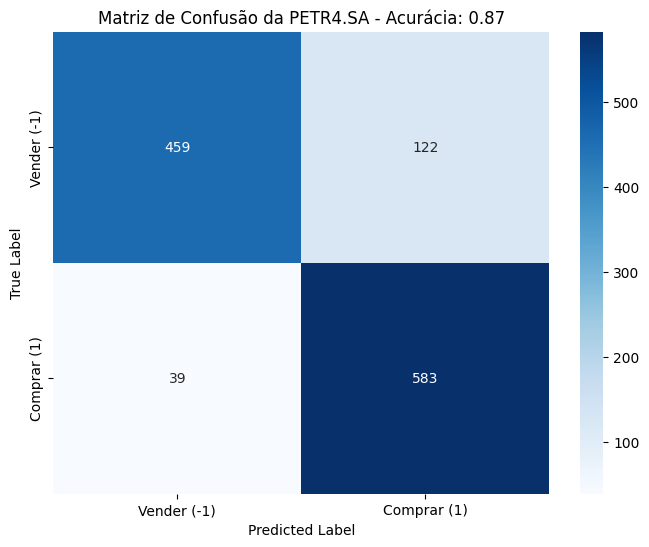

Acurácia PETR4.SA:  0.8661679029464722
Precisão PETR4.SA:  0.826950354609929
Recall PETR4.SA:  0.9372990353697749


In [12]:
# Avaliar o modelo com os dados de teste
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Accuracy {stocks[2]}:', test_accuracy)

predictions = model.predict(test_images)

predicted_labels = np.round(predictions).flatten()
true_labels = test_labels.flatten()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_names = ['Vender (-1)', 'Comprar (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusão da {stocks[2]} - Acurácia: {test_accuracy:.2f}')
plt.show()

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f'Acurácia {stocks[2]}: ', test_accuracy)
print(f'Precisão {stocks[2]}: ', precision)
print(f'Recall {stocks[2]}: ', recall)
